## 1. Загрузка и обработка данных 

In [2]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test

In [3]:
# Считываем данные из файла и проверяем результат
url = 'https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@ds_salaries.zip'
data = pd.read_csv(url, compression='zip', index_col=0)
display(data.head())

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [4]:
# Посмотрим на наличие пропусков и тип данных в столбцах
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


In [5]:
# Выделим категориальные и числовые признаки
cat_features = data.dtypes[data.dtypes == 'object'].index.to_list()
num_features = data.dtypes[data.dtypes == 'int64'].index.to_list()

print(f"Категориальные признаки в данных: {cat_features}")
print(f"Числовые признаки в данных: {num_features}")

Категориальные признаки в данных: ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']
Числовые признаки в данных: ['work_year', 'salary', 'salary_in_usd', 'remote_ratio']


In [6]:
# Проверим количество дубликатов в данных 
print(f'Количество дубликатов в данных: {data.duplicated().sum()}')

# Удалим дубликаты 
data_clean = data.drop_duplicates()
print(f'Количество строк в дастасете после удаления дубликатов: {data_clean.shape[0]}')


Количество дубликатов в данных: 42
Количество строк в дастасете после удаления дубликатов: 565


In [7]:
# Посмотрим на основные статистики для категориальных признаков
display(data_clean.describe(include=object))

# и для числовых признаков
display(data_clean.describe())

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,565,565,565,565,565,565,565
unique,4,4,50,17,57,50,3
top,SE,FT,Data Scientist,USD,US,US,M
freq,243,546,130,359,295,318,290


,work_year,salary,salary_in_usd,remote_ratio
count,565.000000,5.650000e+02,565.000000,565.000000
mean,2021.364602,3.381160e+05,110610.343363,69.911504
std,0.698138,1.599879e+06,72280.702792,40.900666
min,2020.000000,4.000000e+03,2859.000000,0.000000
25%,2021.000000,6.700000e+04,60757.000000,50.000000
50%,2021.000000,1.109250e+05,100000.000000,100.000000
75%,2022.000000,1.650000e+05,150000.000000,100.000000
max,2022.000000,3.040000e+07,600000.000000,100.000000


### Промежуточные выводы:
 + Датасет содержит 607 строк. Пропущенные значения отсутствуют.
 + В датасете было 42 полных дубликата. После их удаления датасет состоит из 565 строк.
 + Имеется 4 числовых признака (Dtype: int64) и 7 категориальных (Dtype: object), что соответствует приведенному в начале описанию признаков.
 + Признак salary_in_usd является производным от признаков salary и salary_currency поэтому скорее всего пользы от последних будет немного. К тому же правильнее будет проводить сравнение величин приведенных к одному масштабу.
 + По основным статистикам категориальных признаков можно обратить внимание, что признаки 'job_title', 'employee_residence', 'company_location' имеют 50 и более уникальных значений. При этом наиболее популярное значение занимает значительную часть наблюдений, более половины для двух последних. Можно попробовать укрупнить категории для удобства анализа.
 + По основным статистикам количественных признаков можно сказать, что признак work_year имеет нормальное распределение (среднее значение и медиана практически равны). Для остальных признаков среднее значение отличается от медианы - скорее всего распределение отлично от нормального.	

## 2. Разведывательный анализ данных 

### 2.1 Визуальный анализ данных 

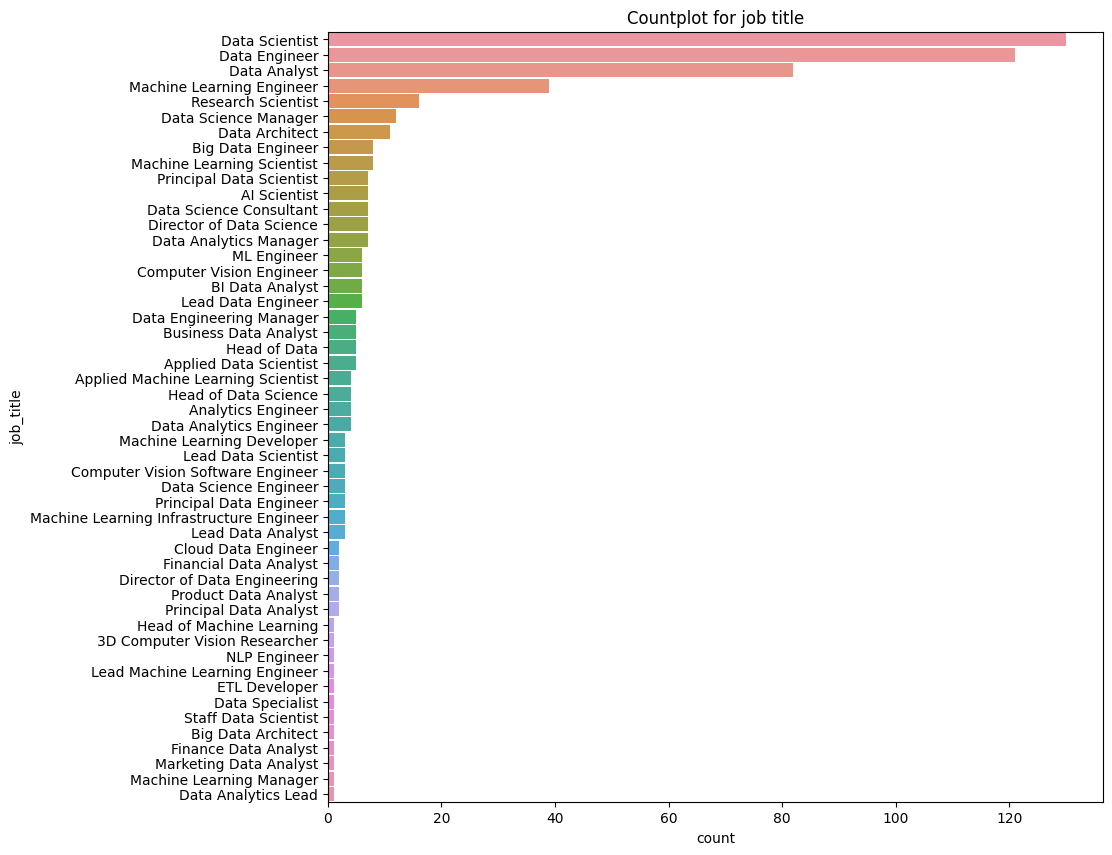

In [8]:
# Посмотрим на распределение профессий по наименованиям
fig = plt.figure(figsize=(10, 10))
sns.countplot(y = data_clean['job_title'],
              orient='h',
              order=data_clean['job_title'].value_counts().index,
              width=0.9).set_title('Countplot for job title');

In [9]:
# Видно, что в данных есть наименования профессий схожих по смыслу. 
# Чтобы не терять информацию будем считать, что к профессиям Data Engineer,
# Data Analyst, Data Scientist относятся все наименования содержащие 
# соответствующий шаблон ['engineer', 'analy', 'scien'].
# Напишем функцию для группировки профессий по классам
def job_class(x: str):    
    """Функция принимает на вход строку х, преобразует её 
    в нижний регистр, ищет в строке совпадение по шаблонам 
    ['engineer', 'analy', 'scien']. И возвращает соответствующее 
    название профессии ('Data Engineer', 'Data Analyst', 
    'Data Scientist'). Если совпадения не нашлось - возвращает 'other'.

    Returns:
        str: наименование профессии
    """
         
    if re.findall(pattern='engineer', string=x.lower()):
        return 'Data Engineer'
    elif re.findall(pattern='analy', string=x.lower()):
        return 'Data Analyst'
    elif re.findall(pattern='scien', string=x.lower()):
        return 'Data Scientist'
    else:
        return 'other'

# Применим функцию и проверим результат    
data_clean.loc[:,['job_class']] = data_clean['job_title'].apply(job_class)
display(data_clean.head())

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_class
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L,Data Scientist
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S,Data Scientist
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M,Data Engineer
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S,Data Analyst
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L,Data Engineer


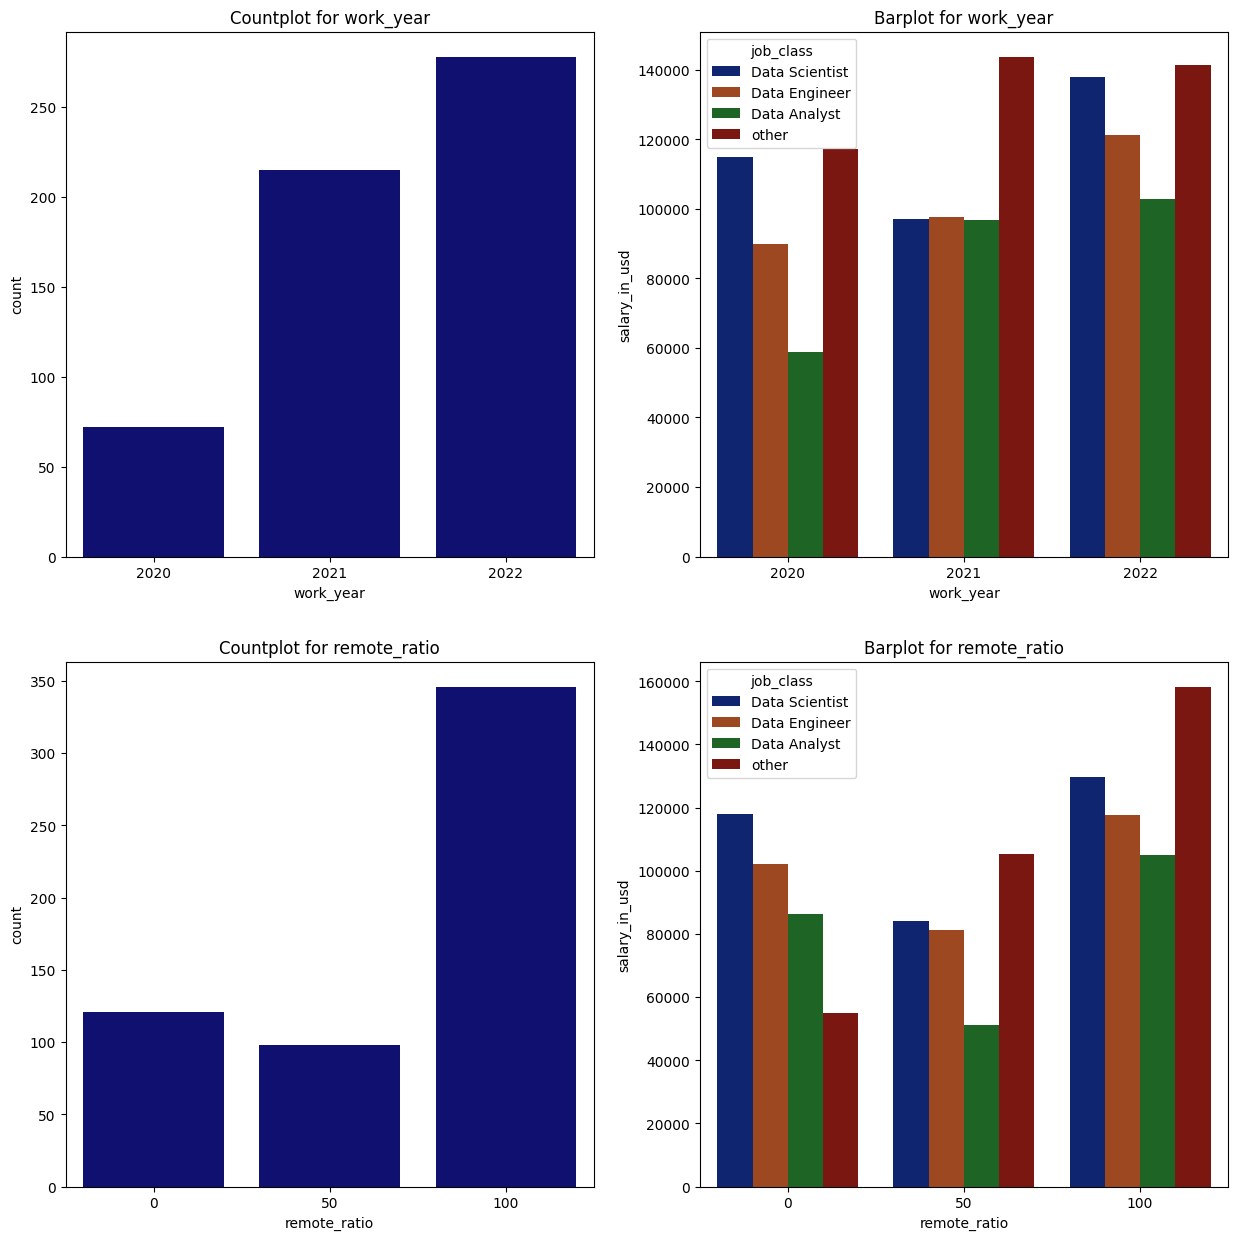

In [10]:
# Из описания признаков понятно, что salary_in_usd является производным от признаков 
# salary и salary_currency использовать их в исследовании не будем. Для начала построим  
# диаграммы для количественных признаков с малым количеством уникальных значений
num_features = ['work_year', 'remote_ratio']

# Создадим полотно из графиков и перебирая в цикле признаки построим гистограммы распределения
# признаков и столбчатые диаграммы зависимости зарплаты от признака. В качестве гисторграммы 
# будем использовать countplot 
fig, axes = plt.subplots(ncols=2, nrows=len(num_features), figsize=(15,15))
for num in range(len(num_features)):
    sns.countplot(data=data_clean,
                  x=num_features[num],
                  ax=axes[num][0],
                  color='navy'
                  ).set_title(f'Countplot for {num_features[num]}');
    
    sns.barplot(data=data_clean,
                x=num_features[num],
                y = 'salary_in_usd',
                hue='job_class',
                errorbar=None,
                ax=axes[num][1],
                palette='dark'
                ).set_title(f'Barplot for {num_features[num]}');

По построенным диграммам можно предположить, что:
 + большинство наблюдений в данных относятся к 2021 и 2022 годам. На 2022 год приходится больше всего наблюдений;
 + в целом за исключением 2021 года, средний уровень зарплат для профессии Data Scientist выше чем у Data Engineer, средняя зарплата которого выше, чем у Data Analyst;
 + наибольшее число наблюдений относится к удаленному виду работы;
 + распределение среднего уровня зарплат по профессиям в зависимости от объема работы, выполняемой удаленно, соответствует предыдущему выводу: средний уровень зарплат для профессии Data Scientist выше чем у Data Engineer, средняя зарплата которого выше, чем у Data Analyst.  


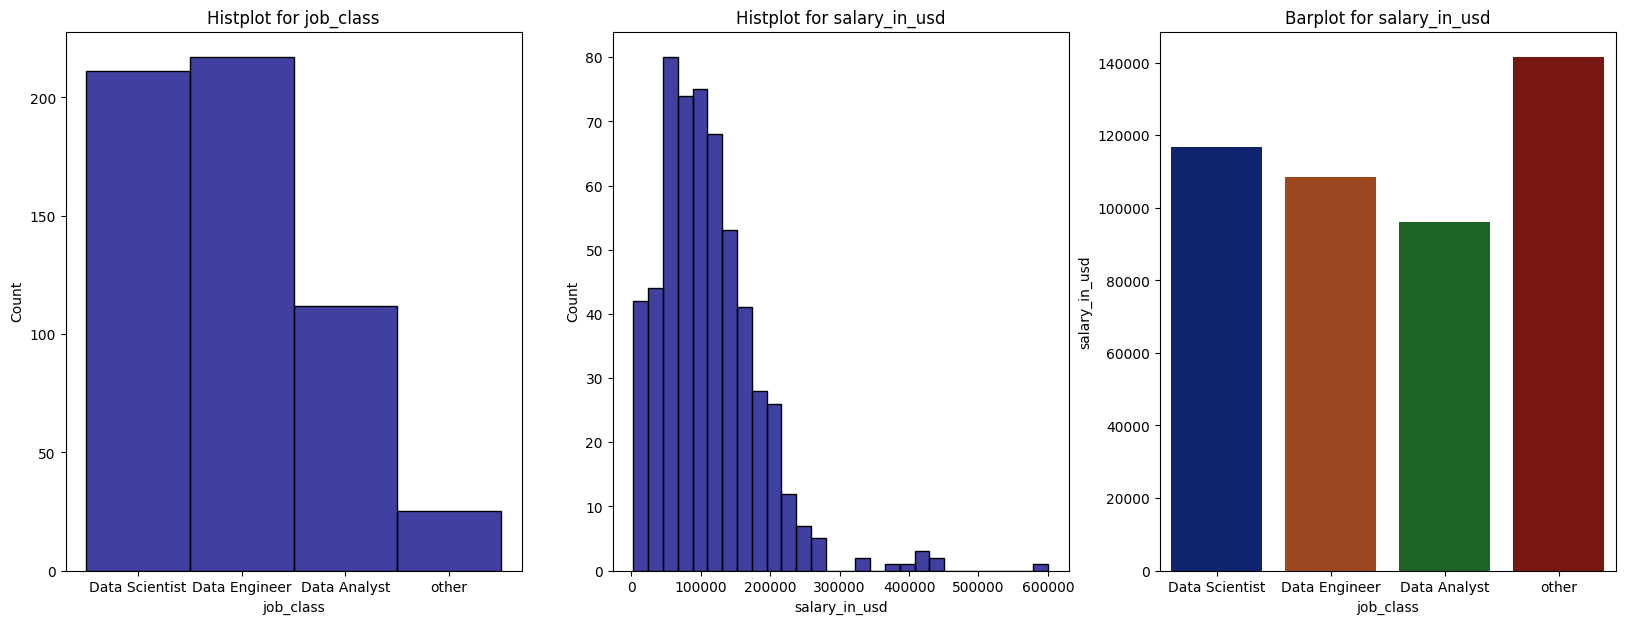

In [11]:
# Построим диаграммы для признаков job_class и salary_in_usd 
# создаем полотно на 3 диаграммы
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,7))

# Строим гистограмму для распределения профессий
sns.histplot(data=data_clean,
              x='job_class',
              color='navy',
              ax=axes[0]
              ).set_title('Histplot for job_class');

# Строим гистограмму для распределения зарплат
sns.histplot(data=data_clean,
              x='salary_in_usd',
              color='navy',
              ax=axes[1]
              ).set_title('Histplot for salary_in_usd');

# Строим столбчатую диаграмму распределения зарплат по профессиям
sns.barplot(data=data_clean,
                x='job_class',
                y = 'salary_in_usd',                
                errorbar=None,
                ax=axes[2],
                palette='dark'
                ).set_title('Barplot for salary_in_usd');

Видно, что в данных соотношение наблюдений по профессиям Data Scientist и Data Engineer близки к друг-другу, в тоже время наблюдений для профессии Data Analyst почти в два раза меньше. Чаще всего встречается зарпалата в диапазоне от 50 до 150 тысяч долларов. соотношение среднего уровня зарплат по профессиям повторяет предыдущие наблюдения: средний уровень зарплат для профессии Data Scientist выше, чем у Data Engineer, средняя зарплата которого выше, чем у Data Analyst.

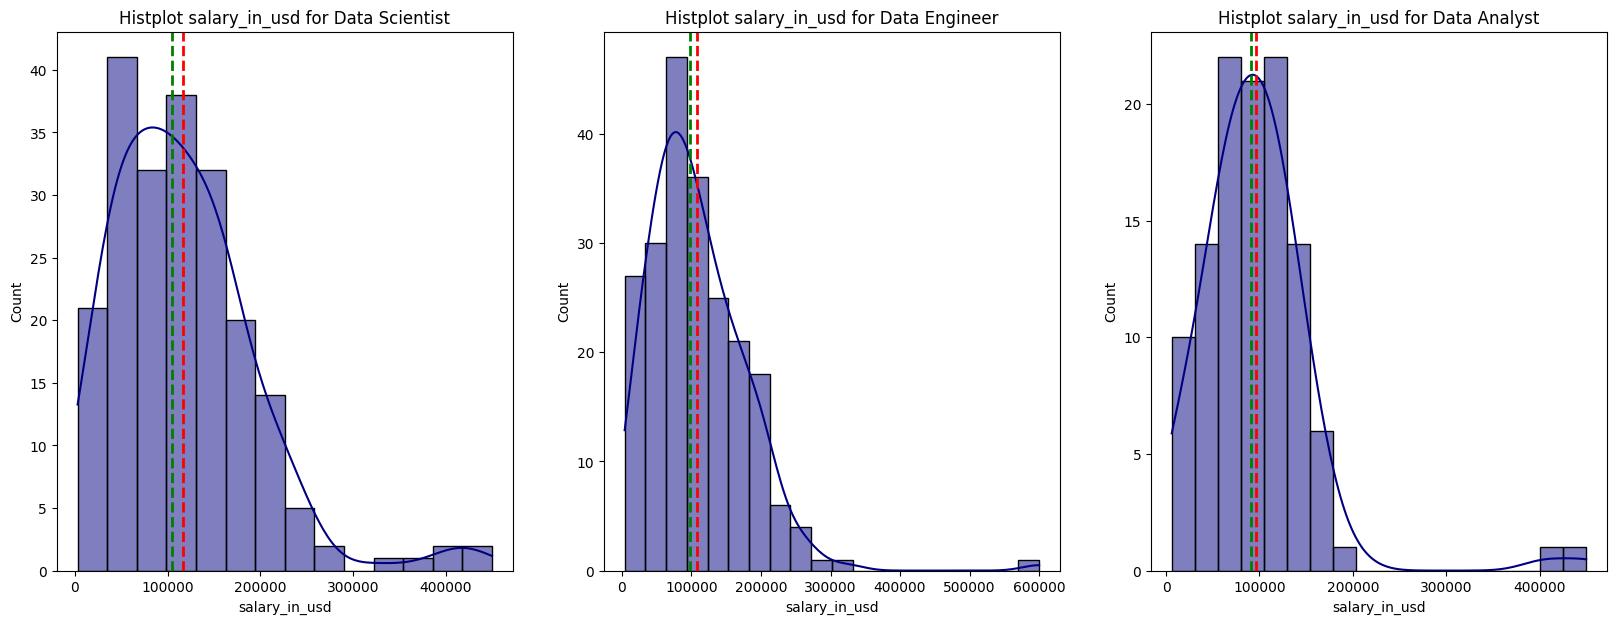

In [12]:
# Построим гистограммы распределения зарплат для основных профессий
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,7))

# Гистрограмма распределения зарплат профессии Data Scientist
sns.histplot(data=data_clean[data_clean['job_class'] == 'Data Scientist'],
              x='salary_in_usd',
              color='navy',
              kde=True,
              ax=axes[0]
              ).set_title('Histplot salary_in_usd for Data Scientist');

# Уровень средней зарплаты для профессии Data Scientist
axes[0].axvline(data_clean[data_clean['job_class'] == 'Data Scientist']['salary_in_usd'].mean(),
                color='red',
                linestyle='--',
                linewidth=2
                )

# Медианное значение зарплаты для профессии Data Scientist
axes[0].axvline(data_clean[data_clean['job_class'] == 'Data Scientist']['salary_in_usd'].median(),
                color='green',
                linestyle='--',
                linewidth=2
                )

# Гистрограмма распределения зарплат профессии Data Engineer
sns.histplot(data=data_clean[data_clean['job_class'] == 'Data Engineer'],
              x='salary_in_usd',
              color='navy',
              kde=True,
              ax=axes[1]
              ).set_title('Histplot salary_in_usd for Data Engineer');

# Уровень средней зарплаты для профессии Data Engineer
axes[1].axvline(data_clean[data_clean['job_class'] == 'Data Engineer']['salary_in_usd'].mean(),
                color='red',
                linestyle='--',
                linewidth=2
                )

# Медианное значение зарплаты для профессии Data Engineer
axes[1].axvline(data_clean[data_clean['job_class'] == 'Data Engineer']['salary_in_usd'].median(),
                color='green',
                linestyle='--',
                linewidth=2
                )

# Гистрограмма распределения зарплат профессии Data Analyst
sns.histplot(data=data_clean[data_clean['job_class'] == 'Data Analyst'],
              x='salary_in_usd',
              color='navy',
              kde=True,
              ax=axes[2]
              ).set_title('Histplot salary_in_usd for Data Analyst');

# Уровень средней зарплаты для профессии Data Analyst
axes[2].axvline(data_clean[data_clean['job_class'] == 'Data Analyst']['salary_in_usd'].mean(),
                color='red',
                linestyle='--',
                linewidth=2
                )

# Медианное значение зарплаты для профессии Data Analyst
axes[2].axvline(data_clean[data_clean['job_class'] == 'Data Analyst']['salary_in_usd'].median(),
                color='green',
                linestyle='--',
                linewidth=2
                );


+ Распределение зарплаты для каждой профессии отлично от нормального. 
+ Медианные и средние значения близки, но не совпадают. 
+ Имеются аномальные значения.

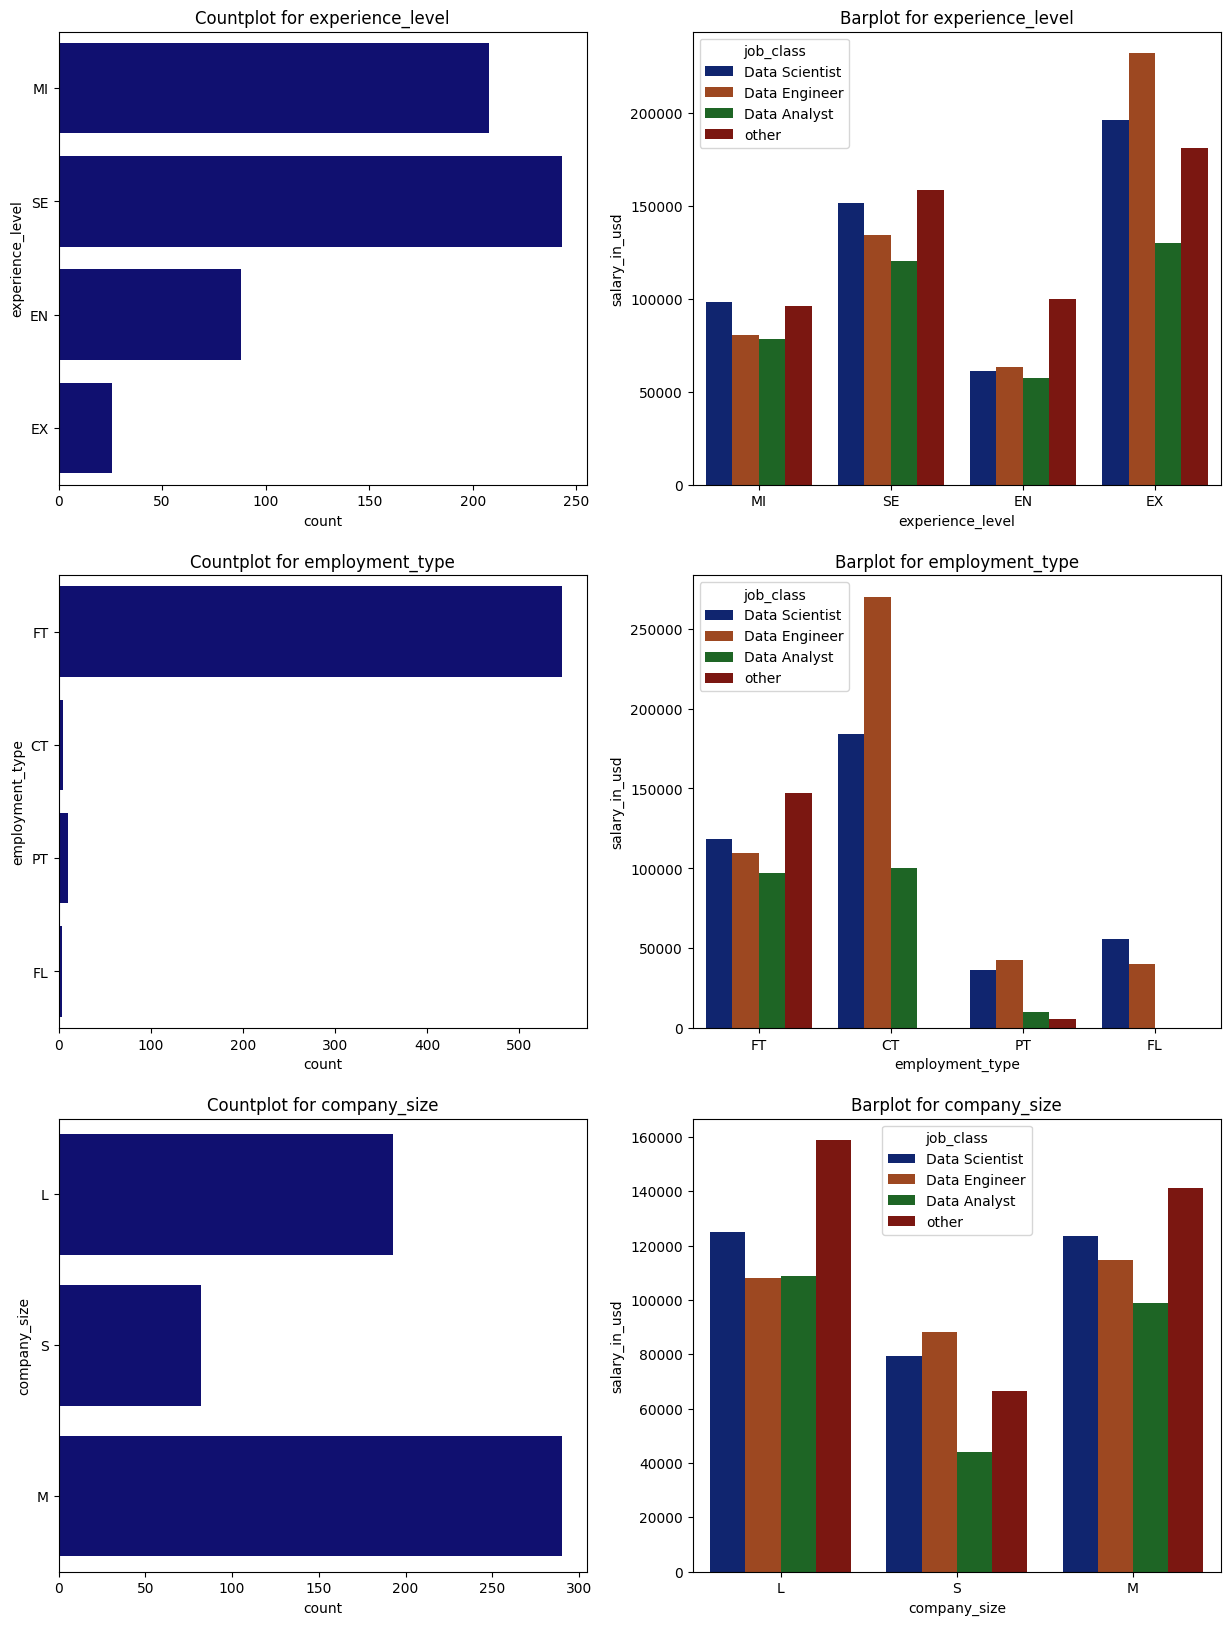

In [13]:
# Выберем категориальные признаки с малым количеством уникальных значений
cat_features = ['experience_level',
                'employment_type',
                'company_size'
                ]

# Создадим полотно из графиков и перебирая в цикле признаки построим гистограммы 
# распределения признаков и столбчатые диаграммы зависимости зарплаты от признака.
# В качестве гисторграммы будем использовать countplot 
fig, axes = plt.subplots(ncols=2, nrows=len(cat_features), figsize=(15,20))
for num in range(len(cat_features)):
    sns.countplot(data=data_clean,
                  y=cat_features[num],
                  ax=axes[num][0],
                  orient='h',                  
                  color='navy'
                  ).set_title(f'Countplot for {cat_features[num]}')
    
    sns.barplot(data=data_clean,
                x=cat_features[num],
                y = 'salary_in_usd',
                hue='job_class',
                errorbar=None,                
                ax=axes[num][1],
                palette='dark'
                ).set_title(f'Barplot for {cat_features[num]}');

+ большинство наблюдений в данных относится к опыту работы Mid-level и Senior-level;
+ в среднем зарпалата Data Scientist и Data Engineer для любого опыта работы выше, чем у Data Analyst. Можно также обратить внимание, что средняя зарплата Data Engineer для опыта работы Entry-level и Executive-level выше чем у Data Scientist, хотя для уровней Mid-level и Senior-level ситуация обратная;
+ большинство наблюдений в данных относятся к типу трудойстройства - полный рабочий день;
+ для профессии Data Scientist средняя зарплата при полном рабочем дне выше, чем у Data Engineer, а у Data Engineer выше, чем у Data Analyst. При работе по контракту и при неполном рабочем дне средняя зарплата для Data Engineer выше, чем у Data Scientist, а у Data Scientist выше, чем у Data Analyst. При работе в формате фриланс отсутствуют наблюдения для профессии Data Analyst, а средняя зарплата Data Scientist выше, чем у Data Engineer;
+ большинство наблюдений в данных относится к средним и большим компаниям.
+ в маленьких компаниях средняя зарплата Data Engineer выше, чем у Data Scientist, а у Data Scientist выше, чем у Data Analyst. В средних компаниях для профессии Data Scientist средняя зарплата выше, чем у Data Engineer, а у Data Engineer выше, чем у Data Analyst. В крупных - средняя зарплата Data Scientist выше, чем у Data Engineer и Data Analyst, средняя зарплата которых находится на одном уровне.

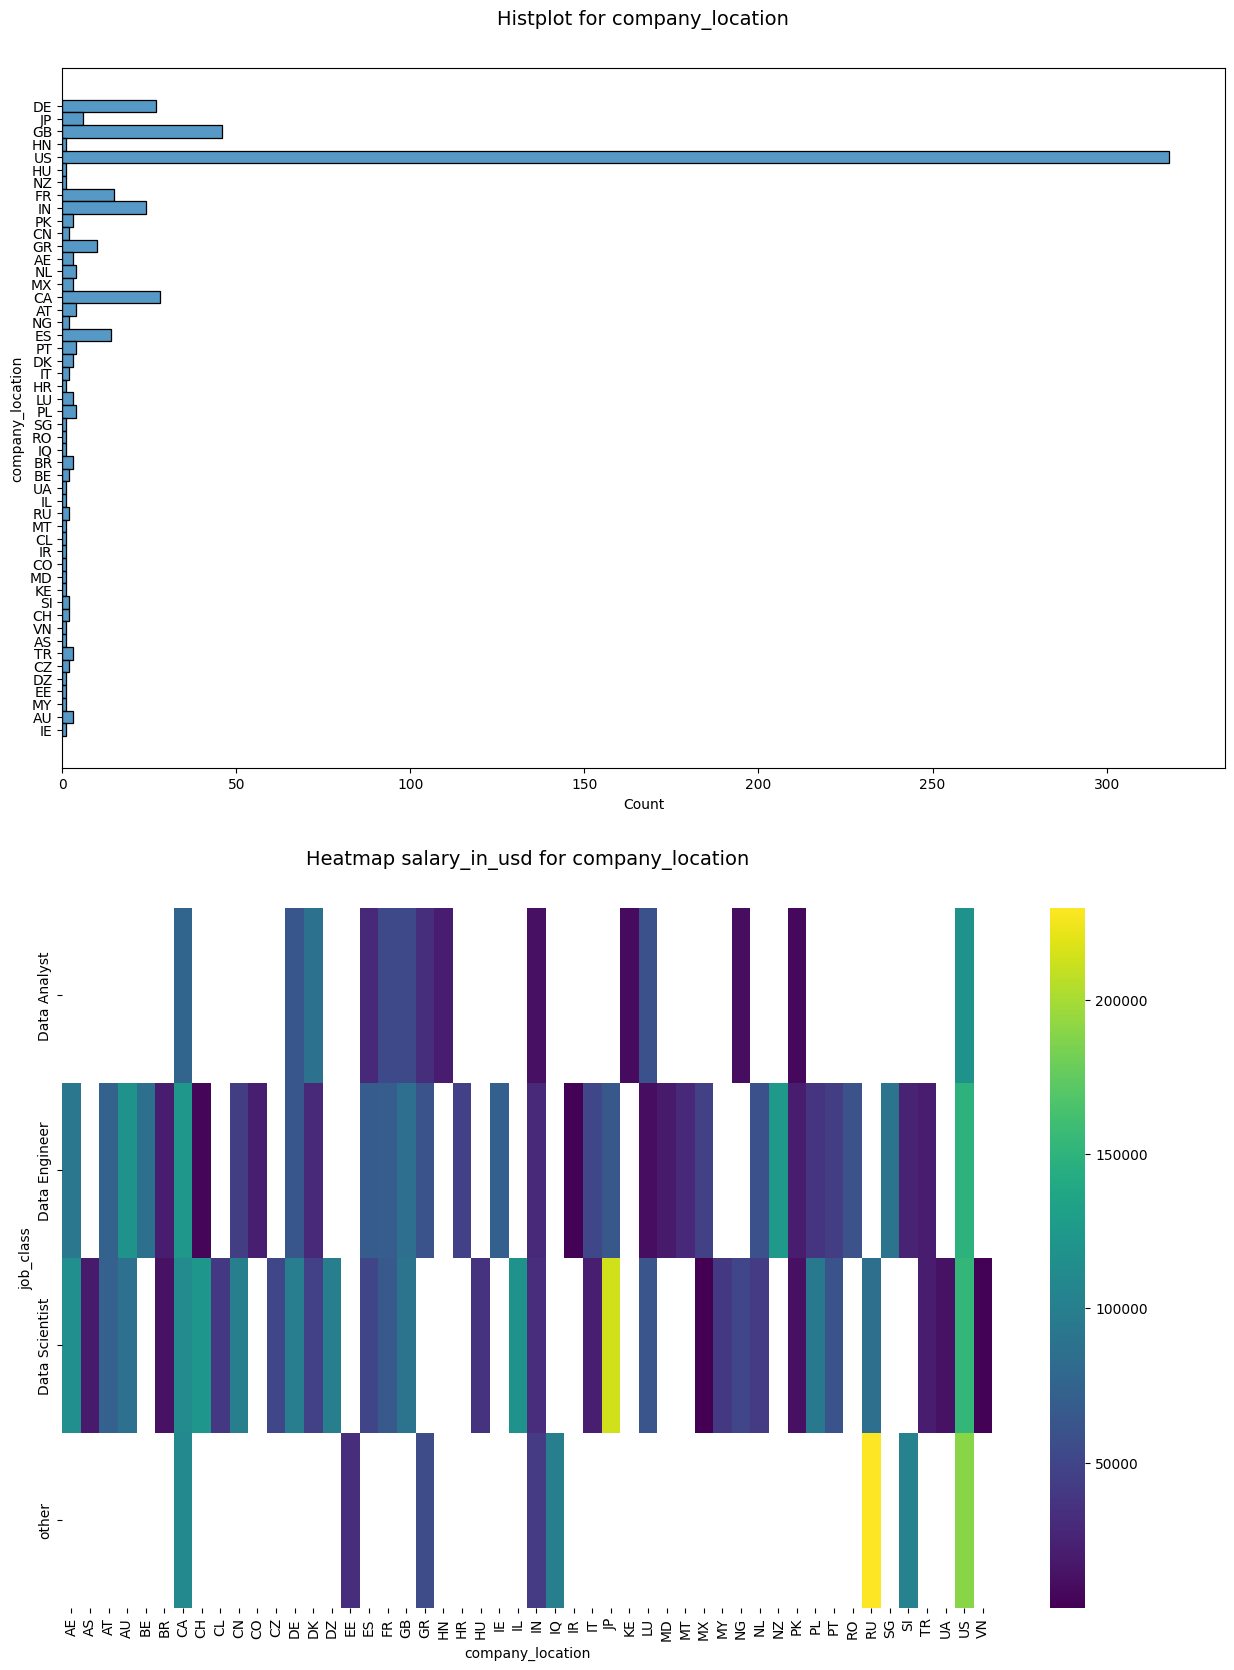

In [14]:
# Теперь построим визуализации для признаков с большим количеством уникальных значений.
# Подготовим данные для тепловой карты
tab = data_clean.pivot_table(index='job_class', 
                             columns='company_location',
                             values='salary_in_usd'
                             )

# Задаем полотно для двух графиков
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 20))

# Строим гистограмму распределения компаний по странам
sns.histplot(y=data_clean['company_location'],
             ax=ax[0]
             ).set_title('Histplot for company_location',
                        y=1.05,
                        fontdict={'fontsize':14}
                        )

# Строим тепловую карту распределения зарплат в зависимости 
# от страны компании для различных профессий
sns.heatmap(tab,
            annot=False,
            ax=ax[1],
            cmap="viridis"
            ).set_title('Heatmap salary_in_usd for company_location',
                        y=1.05,
                        fontdict={'fontsize':14}
                        );

+ большинство наблюдений в данных относятся к компаниям расположенным в США. Далее по количеству наблюдений идут Великобритания, Германия, Канада, Индия, Франция и Испания. Вклад других стран в количество наблюдений значительно меньше;
+ не для всех стран имеются наблюдения по всем группам профессий. Для США, Великобритании, Индии и Франции средняя зарпалата Data Scientist примерно совпадает со средней зарплатой Data Engineer и выше чем у Data Analyst. Для Германии средняя зарплата Data Scientist выше, чем у Data Engineer и Data Analyst, средняя зарплата которых находится на одном уровне. А для Канады и Испании средняя зарплата Data Engineer выше, чем у Data Scientist, средняя зарплата которого выше, чем у Data Analyst.

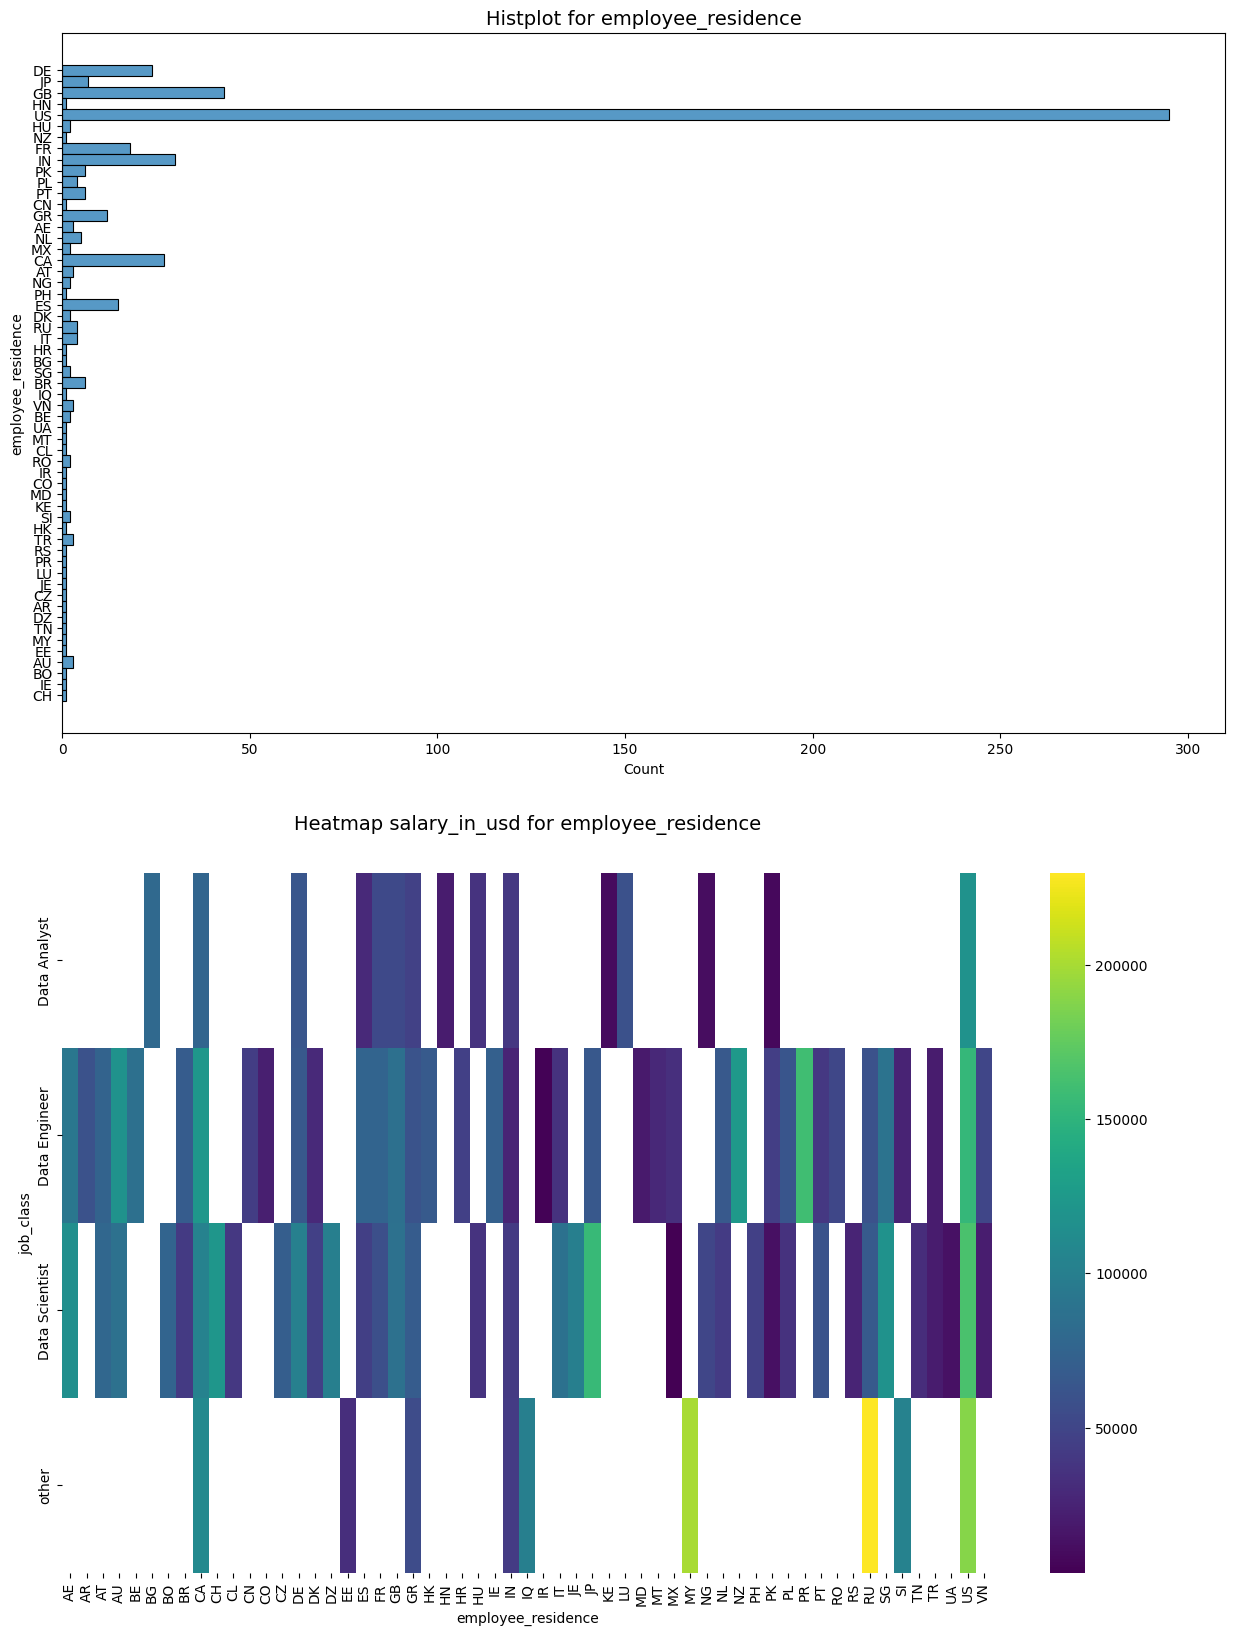

In [15]:
# Подготовим данные для тепловой карты
tab = data_clean.pivot_table(index='job_class', 
                             columns='employee_residence',
                             values='salary_in_usd'
                             )

# Задаем полотно для двух графиков
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 20))

# Строим гистограмму распределения работников по странам проживания
sns.histplot(y=data_clean['employee_residence'],
             ax=ax[0]
             ).set_title('Histplot for employee_residence',
                        y=1,
                        fontdict={'fontsize':14}
                        )

# Строим тепловую карту распределения зарплат в зависимости 
# от страны проживания работника для различных профессий
sns.heatmap(tab,
            annot=False,
            ax=ax[1],
            cmap="viridis"
            ).set_title('Heatmap salary_in_usd for employee_residence',
                        y=1.05,
                        fontdict={'fontsize':14}
                        );

+ большинство наблюдений в данных относятся к работникам основной страной проживания которых является США. Далее по количеству наблюдений идут Великобритания, Индия, Канада, Германия, Франция и Испания. Вклад других стран в количество наблюдений значительно меньше;
+ также не для всех стран имеются наблюдения по всем группам профессий. Для сотрудников в основном проживающих в США и Германии средняя зарпалата Data Scientist выше чем у Data Engineer средняя зарплата которого выше, чем у Data Analyst. Для работников из Канады и Испании средняя зарпалата Data Engineer выше, чем у Data Scientist средняя зарплата которого выше, чем у Data Analyst. Для работников из Великобритании средняя зарпалата Data Engineer и Data Scientist примерно на одном уровне и выше, чем у Data Analyst. Для работников из Индии средняя зарпалата Data Engineer меньше, чем у Data Scientist и Data Analyst средняя зарпалата которых примерно на одном уровне. Для работников из Франции средняя зарпалата Data Engineer выше, чем у Data Scientist и Data Analyst средняя зарпалата которых примерно на одном уровне.

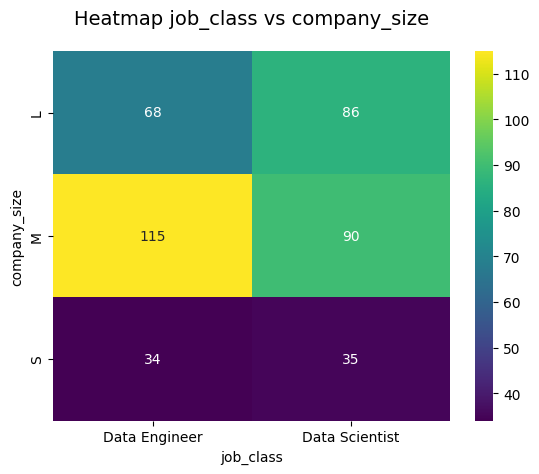

In [16]:
# Построим тепловую карту для определения количества должностей Data Engineer и Data Scientist 
# в компаниях различных размеров.
# Подготовим данные, зададим маску для фильтрации данных
mask = (data_clean['job_class'] == 'Data Scientist')|(data_clean['job_class'] == 'Data Engineer')

# Построим сводную таблицу количества должностей Data Engineer и Data Scientist в компаниях 
# различных размеров
table = data_clean[mask].pivot_table(values='job_title',
                                     index='company_size',
                                     columns='job_class',
                                     aggfunc='count'
                                     )

# Строим теполвую карту
sns.heatmap(table,
            annot=True,
            fmt='g',
            cmap="viridis"
            ).set_title('Heatmap job_class vs company_size',
                        y=1.05,
                        fontdict={'fontsize':14}
                        );


+ видно, что в маленьких компаниях количество должностей Data Scientist и Data Engineer почти идентично;
+ в средних и больших компаниях количество должностей Data Scientist примерно совпадает и выше, чем в маленьких компаниых;
+ количество должностей Data Engineer максимально для средних компаний и падает для больших почти вдвое.

### Промежуточные выводы по визуальному анализу данных:

+ судя по диаграммам ежегодного роста зарплат у специалистов Data Scientist не наблюдается. В 2021 году было снижение зарплат относительно 2020 года. Но в 2022 году уровень зарплат превысил значение 2020 года;
+ в 2022 году зарплата специалистов Data Scientist превышала зарплаты специалистов Data Engineer;
+ наблюдается рост зарплат специалистов Data Scientist с увеличением размера компании;
+ для маленьких компаний количество должностей Data Scientist и Data Engineer практически одинаково, для средних и больших компаний количество должностей Data Scientist примерно одинаковое, а количество должностей Data Engineer максимально для средних компаний и падает для больших компаний.
+ в качестве дополнительных исследований выберем проверку следующих, выдвинутых на основе визуального анализа гипотез:
   + средняя зарплата Data Engineer для опыта работы Entry-level и Executive-level выше чем у Data Scientist;
   + для компаний Канады и Испании средняя зарплата Data Engineer выше, чем у Data Scientist, средняя зарплата которого выше, чем у Data Analyst;
   + можно проверить соотношение объема выполняемых удаленно работ и размера компании (визуальный анализ приведм в блоке с дополнительными исследованиями, чтобы не повторять построение таблицы сопряженности).


### 2.2 Статистический анализ данных 

In [17]:
# Для удобства напишем функции для принятия решений по гипотезам
# функция для принятия решения о нормальности
def decision_normality(p, alpha=0.05):
    """Функция принимает p-значение и выводит сообщение 
    о характере распределения данных в выборке. Значение 
    alpha опционально, по умолчанию задано равным 0.05

    Args:
        p (float): p-значение
        alpha (float, optional): уровень значимости, по умолчанию 0.05.
    """    
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p, alpha=0.05):
    """Функция принимает p-значение и выводит сообщение 
    о возможности принятия нулевой гипотезы. Значение 
    alpha опционально, по умолчанию задано равным 0.05

    Args:
        p (float): p-значение
        alpha (float, optional): уровень значимости, по умолчанию 0.05.
    """
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

### 2.2.1 Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Для ответа на этот вопрос будем проводить сравнение со средним или медианным уровнем зарплаты за предыдущий год (m_salary_past).                
Зарплата - количественный признак, количество сравниваемых групп - одна следовательно нам подходит одновыборочный t-критерий или критерий знаков для одной группы в зависимости от распределения признака. 

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.              
Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [18]:
# Выберем данные относящиеся к профессии Data Scientist
ds_data = data_clean[data_clean['job_class'] == 'Data Scientist']

# значения зарпалат специалистов Data Scientist в 2021 и 2022 годах
ds_salary_21 = ds_data.loc[ds_data['work_year'] == 2021, 'salary_in_usd']
ds_salary_22 = ds_data.loc[ds_data['work_year'] == 2022, 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для 2021 года:')
result = stats.shapiro(ds_salary_21)
decision_normality(result[1])
print()

print('Для 2022 года:')
result = stats.shapiro(ds_salary_22)
decision_normality(result[1])

Для 2021 года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для 2022 года:
p-value = 0.025
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Распределение признака отлично от нормального поэтому нам подойдет непараметрический тест **критерий знаков для одной группы**


**Сформулируем нулевую и альтернативную гипотезы:**

*Нулевая гипотеза* ($H_0$): медианная зарплата специалистов Data Scientist ($μ$) равна $m\_salary\_past$.

$$ H_0 : μ = m\_salary\_past$$

*Альтернативная гипотеза* ($H_1$): медианная зарплата специалистов Data Scientist ($μ$) не равна $m\_salary\_past$.

$$ H_1 : μ\ \neq  m\_salary\_past$$

In [19]:
# Зададим медианное значение
m_salary_20 = ds_data.loc[ds_data['work_year'] == 2020, 'salary_in_usd'].median()
m_salary_21 = ds_data.loc[ds_data['work_year'] == 2021, 'salary_in_usd'].median()

# Проводим тест на проверку гипотезы для 2021
print('Тест для 2021 года: ')
_,p = sign_test(ds_salary_21, m_salary_20)
decision_hypothesis(p)
print()

# Проводим тест на проверку гипотезы для 2022
print('Тест для 2022 года: ')
_,p = sign_test(ds_salary_22, m_salary_21)
decision_hypothesis(p)

Тест для 2021 года: 
p-value = 0.834
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.

Тест для 2022 года: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**       
Результаты статистических тестов показывают, что для 2021 года медианное значение зарпалат соответствует 2020 году. Для 2022 года медиана зарплаты для специалистов Data Scientist изменилась по сравнению с 2021 годом. В целом можно заключить, что для специалистов Data Scientist не наблюдается ежегодный рост зарплат.

### 2.2.2 Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?      

Выберем тест:
+ Тип признака (зарплата) - количественный признак;
+ количество сравниваемых групп - две; 
+ группы независимые;         

следовательно нам подходит двувыборочный t-критерий или u - критерий Манна-Уитни в зависимости от распределения признака.

Проверку на нормальность для выборки зарплат Data Scientist в 2022 году мы сделали в предыдущем тесте - рапределение было отлично от нормального. Если в хотя бы одной выборке рапределение не соответствует нормальному мы должны выбрать непараметрический тест т.е. u - критерий Манна-Уитни

Согласно документации: 
U-критерий Манна-Уитни — это непараметрическая проверка нулевой гипотезы о том, что распределение, лежащее в основе выборки x, такое же, как распределение, лежащее в основе выборки y. 
Пусть F(u) и G(u) — кумулятивные функции распределения распределений, лежащих в основе x и y соответственно. Тогда возможны следующие альтернативные гипотезы:

  + «двусторонняя»: распределения не равны, т.е. F(u) ≠ G(u) хотя бы для одного u.

  + «меньше»: распределение, лежащее в основе x , стохастически меньше, чем распределение, лежащее в основе y , т.е. F(u) > G(u) для всех u.

  + «больше»: распределение, лежащее в основе x , стохастически больше, чем распределение, лежащее в основе y , т.е. F(u) < G(u) для всех u.

Обратите внимание, что математические выражения в альтернативных гипотезах, приведенных выше, описывают CDF основных распределений. На первый взгляд направления неравенств кажутся несовместимыми с описанием на естественном языке, но это не так. Например, предположим, что X и Y — случайные величины, которые следуют распределениям с CDF F и G соответственно. Если F(u) > G(u) для всех u, образцы, взятые из X, имеют тенденцию быть меньше, чем образцы, взятые из Y.           
Кумулятивная функция распределения (CDF) описывает вероятности случайной величины, имеющей значения, меньшие или равные x.

По результатам визуального анализа мы предположили, что в 2022 году зарплаты Data Scientist превышали зарплаты Data Engineer.

**Сформулируем гипотезы**

*Нулевая гипотеза* ($H_0$): CDF распределение зарплаты Data Scientist ($μ_1$) больше или равно CDF распределению зарплаты Data Engineer ($μ_2$) в 2022 году.  

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): CDF распределение зарплаты Data Scientist ($μ_1$) меньше CDF распределению зарплаты Data Engineer ($μ_2$) в 2022 году.

$$ H_1 : μ_1 < μ_2$$


In [20]:
# Выберем данные относящиеся к профессии Data Engineer
de_data = data_clean[data_clean['job_class'] == 'Data Engineer']

# Значения зарпалат специалистов Data Scientist в 2021 и 2022 годах
ds_salary_22 = ds_data.loc[ds_data['work_year'] == 2022, 'salary_in_usd']
de_salary_22 = de_data.loc[de_data['work_year'] == 2022, 'salary_in_usd']

# Проводим тест и интерпретируем результат
_,p =stats.mannwhitneyu(ds_salary_22, de_salary_22, alternative='greater')
decision_hypothesis(p)

p-value = 0.019
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**          
Результат статистического теста показывает, что в 2022 года зарпалаты специалистов Data Scientist были больше зарпалат специалистов Data Engineer.

### 2.2.3 Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
Выберем тест:
+ Тип признака (зарплата) - количественный признак;
+ количество сравниваемых групп - три; 
+ группы независимые;         

следовательно нам подходит однофакторный дисперсионный анализ или критерий Краскела-Уоллиса в зависимости от распределения признака в выборках.


**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально в каждой из трех групп.              
Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [21]:
# Подготовим выборки по размеру компаний
ds_small_inc = ds_data.loc[ds_data['company_size'] == 'S', 'salary_in_usd']
ds_medium_inc = ds_data.loc[ds_data['company_size'] == 'M', 'salary_in_usd']
ds_large_inc = ds_data.loc[ds_data['company_size'] == 'L', 'salary_in_usd']

# проводим тест Шапиро-Уилка и интерпретируем результат
print('Для маленьких компаний:')
result = stats.shapiro(ds_small_inc)
decision_normality(result[1])
print()

print('Для средних компаний:')
result = stats.shapiro(ds_medium_inc)
decision_normality(result[1])
print()

print('Для больших компаний:')
result = stats.shapiro(ds_large_inc)
decision_normality(result[1])
print()


Для маленьких компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для средних компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для больших компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального



Распределение признака отлично от нормального поэтому нам подойдет непараметрический тест **критерий Краскела - Уоллиса**

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: медианное значение зарплат специалистов Data Scientist в компаниях различных размеров (маленькие ($μ_1$), средние ($μ_2$), большие ($μ_3$)) одинаково.

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: медианное значение зарплат специалистов Data Scientist в компаниях различных размеров (маленькие ($μ_1$), средние ($μ_2$), большие ($μ_3$)) отличается.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

In [22]:
# проводим тест и интерпритируем результат
_, p = stats.kruskal(ds_small_inc, ds_medium_inc, ds_large_inc)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**  
Результаты статистических тестов показывают, что существует разница в зарплатах специалистов Data Scientist в компаниях различных размеров.

### 2.2.4 Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Здесь требуется проверка наличия связи между двумя категориальными признаками - нам подойдет тест хи-квадрат.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: отсутствует взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.

*Альтернативная гипотеза*: существует взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.

In [23]:
# Делаем выборку для профессий Data Scientist и Data Engineer
ds_de_data = data_clean[(data_clean['job_class'] == 'Data Scientist')|(data_clean['job_class'] == 'Data Engineer')]

# Создаем таблицу сопряженности
table = pd.crosstab(ds_de_data['job_class'], ds_de_data['company_size'])
display(table)

# Значений в каждой ячейке больше 5, значит условие применимости теста
# хи-квадрат выполняется. Проводим тест и интерпретируем результат
_,p,_,_ = stats.chi2_contingency(table)
decision_hypothesis(p)

company_size,L,M,S
job_class,,,
Data Engineer,68,115,34
Data Scientist,86,90,35


p-value = 0.079
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:**    
У нас нет оснований утверждать, что существует взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.

## 2.3 Дополнительные исследования

### 2.3.1 При визуальном анализе мы обратили внимание, что средняя зарплата Data Engineer для опыта работы Entry-level и Executive-level выше чем у Data Scientist.            
Проверим эту гипотезу в каждой группе опыта работы.             
Подберем тест: 
 + признак количественный;
 + групп две;
 + группы независимы.
Нам подходит тест двувыборочный t-критерий или u - критерий Манна-Уитни в зависимости от распределения признака.

**Проверка на нормальность**

In [31]:
# Создаем выборки данных для каждой группы
en_ds_salary = ds_data[ds_data['experience_level'] == 'EN']['salary_in_usd']
en_de_salary = de_data[de_data['experience_level'] == 'EN']['salary_in_usd']

ex_ds_salary = ds_data[ds_data['experience_level'] == 'EX']['salary_in_usd']
ex_de_salary = de_data[de_data['experience_level'] == 'EX']['salary_in_usd']

# проводим тест Шапиро-Уилка для каждой группы
print('Для DS с опытом работы EN')
result = stats.shapiro(en_ds_salary)
decision_normality(result[1])
print()

print('Для DE с опытом работы EN')
result = stats.shapiro(en_de_salary)
decision_normality(result[1])
print()

print('Для DS с опытом работы EX')
result = stats.shapiro(ex_ds_salary)
decision_normality(result[1])
print()

print('Для DE с опытом работы EX')
result = stats.shapiro(ex_de_salary)
decision_normality(result[1])
print()

Для DS с опытом работы EN
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для DE с опытом работы EN
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для DS с опытом работы EX
p-value = 0.418
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для DE с опытом работы EX
p-value = 0.032
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального




Рапределение только в одной группе является нормальным. Выбраем непараметрический тест u - критерий Манна-Уитни.

**Сформулируем гипотезы**

*Нулевая гипотеза* ($H_0$): CDF распределение зарплаты Data Engineer ($μ_1$) больше или равно CDF распределению зарплаты Data Scientist ($μ_2$).  

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): CDF распределение зарплаты Data Engineer ($μ_1$) меньше CDF распределению зарплаты Data Scientist ($μ_2$).

$$ H_1 : μ_1 < μ_2$$



In [25]:
# Проводим тест для каждой группы опыта работы и интерпретируем результат
print('Для опыта работы EN: ')
_,p =stats.mannwhitneyu(en_de_salary, en_ds_salary, alternative='greater')
decision_hypothesis(p)
print()

print('Для опыта работы EX: ')
_,p =stats.mannwhitneyu(ex_de_salary, ex_ds_salary, alternative='greater')
decision_hypothesis(p)

Для опыта работы EN: 
p-value = 0.563
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.

Для опыта работы EX: 
p-value = 0.381
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:** 

По результатам теста в обоих случаях у нас нет оснований отвергнуть нулевую гипотезу. Значит CDF распределение зарплаты Data Scientist больше или равно CDF распределению зарплаты Data Engineer. То есть в обоих случаях значения зарплат для Data Engineer не превышает значения зарплат Data Scientist

### 2.3.2 На этапе визуального анализа мы сформулировали гипотезу, что для компаний Канады и Испании средняя зарплата Data Engineer выше, чем у Data Scientist, средняя зарплата которого выше, чем у Data Analyst.

Проверим дествительно ли есть разница между зарплатами специалистов работающих в компаниях Канады и Испании.

Выберем тест:
+ тип признака (зарплата) - количественный признак;
+ количество сравниваемых групп - три; 
+ группы независимые;         

следовательно нам подходит однофакторный дисперсионный анализ или критерий Краскела-Уоллиса в зависимости от распределения признака в выборках.

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально в каждой из трех групп.              
Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [26]:
# Выберем данные относящиеся к интересующим нас страннам
loc_data = data_clean[data_clean['company_location'].isin(['CA', 'ES'])]

# Подготовим выборки по зарплатам специалистов 
ds_salary = loc_data.loc[loc_data['job_class'] == 'Data Scientist', 'salary_in_usd']
de_salary = loc_data.loc[loc_data['job_class'] == 'Data Engineer', 'salary_in_usd']
da_salary = loc_data.loc[loc_data['job_class'] == 'Data Analyst', 'salary_in_usd']

# проводим тест Шапиро-Уилка и интерпретируем результат
print('Для Data Scientist:')
result = stats.shapiro(ds_small_inc)
decision_normality(result[1])
print()

print('Для Data Engineer:')
result = stats.shapiro(ds_medium_inc)
decision_normality(result[1])
print()

print('Для Data Analyst:')
result = stats.shapiro(ds_large_inc)
decision_normality(result[1])
print()


Для Data Scientist:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для Data Engineer:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для Data Analyst:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального



Распределение признака отлично от нормального во всех группах, поэтому нам подойдет непараметрический тест **критерий Краскела - Уоллиса**

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: медианное значение зарплат специалистов (Data Scientist ($μ_1$), Data Engineer ($μ_2$), Data Analyst ($μ_3$)), работающих в компаниях Канады и Испании одинаково.

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: медианное значение зарплат специалистов (Data Scientist ($μ_1$), Data Engineer ($μ_2$), Data Analyst ($μ_3$)), работающих в компаниях Канады и Испании отличается.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

In [30]:
# проводим тест и интерпритируем результат
_, p = stats.kruskal(ds_small_inc, ds_medium_inc, ds_large_inc)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**  
Результаты статистических тестов показывают, что существует разница в зарплатах специалистов Data Scientist, Data Engineer и Data Analyst, работающих в компаниях Канады и Испании.

### 2.3.3 Проверим гипотезу о существовании связи между объемом работ выполняемых удаленно и размером компании.

Признаки категориальные нам подойдет тест хи-квадрат. Для применения теста нужно убедится, что в каждой ячейке таблицы сопряженности присутствует не менее 5 объектов.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: признаки объема работ выполняемых удаленно и размер компании независимы.

*Альтернативная гипотеза*: существует взаимосвязь между объемом работ выполняемых удаленно и размер компании.

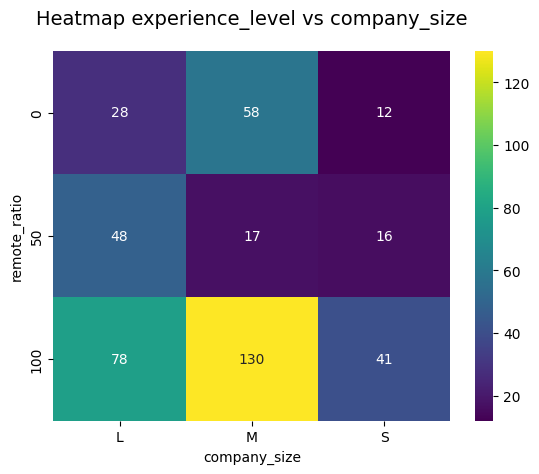

In [28]:
# Строим таблицу сопряженности
table = pd.crosstab(ds_de_data['remote_ratio'], ds_de_data['company_size'])

# Строим теполвую карту
sns.heatmap(table,
            annot=True,
            fmt='g',
            cmap="viridis"
            ).set_title('Heatmap experience_level vs company_size',
                        y=1.05,
                        fontdict={'fontsize':14});

Количество объектов в каждой ячейке таблицы сопряженности больше 5 - критерий применимости теста хи-квадрат выполняется. По визуальному анализу можно выделить следующие взаимосвязи:
+ для средних компаний характерна удаленная работа или полная занятость,
+ для малых компаний преобладает удаленная работа, 
+ для крупных компаний наблюдается почти пропорцианальный рост в сторону увеличения объема работ выполняемых удаленно. 

Проведем статистический тест для проверки наличия связи между этими признаками

In [29]:
# Проводим тест и интерпретируем результат
_,p,_,_ = stats.chi2_contingency(table)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**          
Результат статистического теста показывает, что существует взаимосвязь между объемом работ выполняемых удаленно и размер компании

## Общие выводы

По итогам статистического анализа:

+ Для 2021 года медианное значение зарпалат соответствует 2020 году. Для 2022 года медиана зарплаты для специалистов Data Scientist изменилась по сравнению с 2021 годом. В целом можно заключить, что для специалистов Data Scientist не наблюдается ежегодный рост зарплат. В общем это подтверждает результаты визуального анализа. Исключением является падения зарплат в 2021 году по диаграмме, однако тест показал, что отсутствие этой разницы.

+ Зарпалаты специалистов Data Scientist были больше зарпалат специалистов Data Engineer в 2022 года. По результатам визуального анализа вывод был идентичен.

+ Существует разница в зарплатах специалистов Data Scientist в компаниях различных размеров. Это соответствует выводу визуального анализа  росте зарплат специалистов Data Scientist с ростом размера компании.

+ У нас нет оснований утверждать, что существует взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании. По результатам визуального анализа мы увидели, что распределение количества должностей Data Scientist и Data Engineer в компаниях разных размеров различается. Зависимость можно проследить если рассматривать каждую должность отдельно, но при рассмотрении их совокупности можно сказать об отсутствии взаимосвязи с размером компании, что подтвердилось по результатам теста.

+ В результате визуального анализа выдвинуто предположение, что средняя зарплата Data Engineer для опыта работы Entry-level и Executive-level выше чем у Data Scientist. Однако тест показал, что значения зарплат для Data Engineer не превышает значения зарплат Data Scientist в обоих случаях. 

+ Результаты статистических тестов показывают, что существует разница в зарплатах специалистов Data Scientist, Data Engineer и Data Analyst, работающих в компаниях Канады и Испании. Это подтверждает результаты визуального анализа.

+ По визуальному анализу можно предположить наличие нелинейной взаимосвязи признаков соотношения объема выполняемых удаленно работ и размера компании Наблюдается тенденция к росту объема работ по вобъемам работ выполняемым удаленно и в офисе от малых к средним компаниям и падение к крупным. Исключение составляет объем работ выполняемых на 50% удаленно - эта категория сохраняет рост с ростом размера компании. Статистический тест также показывает наличие связи между этими признаками.




